## `jump` step

This step detects jumps in the pixel ramps by looking for outliers. On output, the GROUPDQ array is updated with the DQ flag JUMP_DET to indicate the location of each jump that was found. 

Official documentation for `jump` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/index.html>


### Input data

An example of running the `jump` step is now shown using a simple simulated observation of a galaxy with the MIRI Imager (F1130W filter) produced with [MIRISim v2.3](https://wiki.miricle.org/Public/MIRISim_Public), with precending pipeline steps applied, i.e. `refpix` output.

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

Import `jump` and print the docstring and spec to show some information

In [2]:
# import the step
from jwst.jump import jump_step

# print the description and options
print(jump_step.JumpStep.__doc__)
print(jump_step.JumpStep.spec)



    JumpStep: Performs CR/jump detection on each ramp integration within an
    exposure. The 2-point difference method is applied.
    

        rejection_threshold = float(default=4.0,min=0) # CR sigma rejection threshold
        maximum_cores = option('none', 'quarter', 'half', 'all', default='none') # max number of processes to create
        flag_4_neighbors = boolean(default=True) # flag the four perpendicular neighbors of each CR
        max_jump_to_flag_neighbors = float(default=200) # maximum jump sigma that will trigger neighbor flagging
        min_jump_to_flag_neighbors = float(default=10) # minimum jump sigma that will trigger neighbor flagging
    


Set the name of the input file and run the step. This will produce an output file ending with `_jumpstep.fits`

*Parameters used:*

`output_use_model` : boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; propagate the input filename to the output
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file

Note that the `jump` will return the output datamodel so we set this to the `dm` variable.


In [3]:
# user specified
my_input_file = 'det_image_seq1_MIRIMAGE_F1130Wexp1_refpixstep.fits'

# run the step
dm = jump_step.JumpStep.call(my_input_file, output_use_model=True, save_results=True)


2020-10-29 14:10:10,970 - CRDS - ERROR -  Error determining best reference for 'pars-jumpstep'  =   Unknown reference type 'pars-jumpstep'
2020-10-29 14:10:10,973 - stpipe.JumpStep - INFO - JumpStep instance created.
2020-10-29 14:10:11,061 - stpipe.JumpStep - INFO - Step JumpStep running with args ('det_image_seq1_MIRIMAGE_F1130Wexp1_refpixstep.fits',).
2020-10-29 14:10:11,063 - stpipe.JumpStep - INFO - Step JumpStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}
2020-10-29 14:10:11,351 - stpipe.JumpStep - INFO - CR rejection threshold = 4 sigma
2020-10-29 14:10:11,357 - stpipe.JumpStep - INFO - Using GAIN reference file

We can plot the location of detected jumps

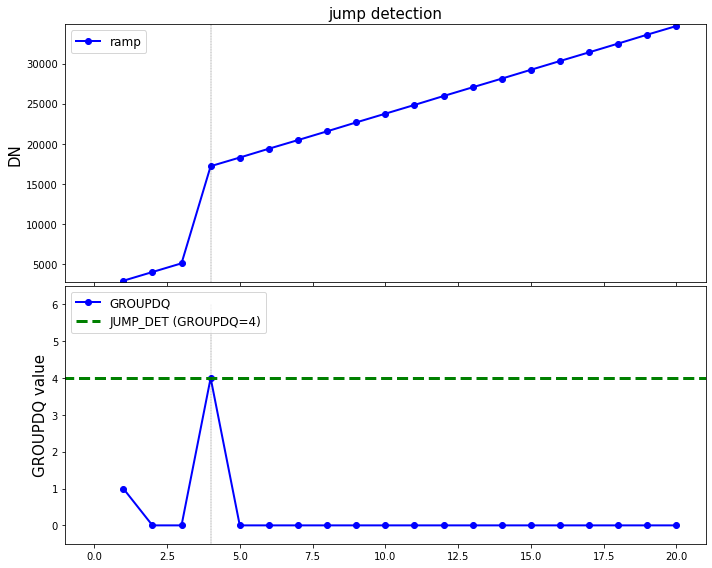

In [5]:
# set the sample pixel (selected knowing there is a jump on the ramp)
pixel = [550, 393]

# define group numbers for integration ramps
group = range(1,dm.data[0,:,pixel[1],pixel[0]].shape[0]+1,1)

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# first integration for input/output ramps
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='ramp')
axs[0].set_title('jump detection',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].set_ylim(min(dm.data[0,:,pixel[1],pixel[0]])-200,max(dm.data[0,:,pixel[1],pixel[0]])+200)
axs[0].legend(prop={'size':12}, loc=2)

# DQ flag values
axs[1].plot(group, dm.groupdq[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', 
            linewidth=2, label='GROUPDQ')
axs[1].plot([-10,100],[4,4], linestyle='--', linewidth=3, c='g', label='JUMP_DET (GROUPDQ=4)')
axs[1].set_ylabel('GROUPDQ value',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,6.5)
axs[1].legend(prop={'size':12}, loc=2)

# draw lines to show the groups which have been flagged as jumps
for n, val in enumerate(group):
    if (dm.groupdq[0,n,pixel[1],pixel[0]] >= 4): 
        axs[0].plot([n+1,n+1],[min(dm.data[0,:,pixel[1],pixel[0]])-200,max(dm.data[0,:,pixel[1],pixel[0]])+200], 
                    linestyle='--', linewidth=0.3, c='k')
        axs[1].plot([n+1,n+1],[-1,6], linestyle='--', linewidth=0.3, c='k')

plt.tight_layout(h_pad=0)
plt.show()



### Command line

To achieve the same result from the command line there are a couple of options. 

**Option 1:**
Run the `JumpStep` class using the `strun` command:

```bash
strun jwst.jump.JumpStep det_image_seq1_MIRIMAGE_F1130Wexp1_refpixstep.fits
```

**Option 2:**
If they don't already exist, collect the pipeline configuration files in your working directory using `collect_pipeline_configs` and then run the `JumpStep` using the `strun` command with the associated `jump.cfg` file. 

```bash
collect_pipeline_cfgs cfgs/

strun cfgs/jump.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_refpixstep.fits
```

This will produce the same output file ending with `_jumpstep.fits` 


A full list of the command line options are given by running the following:

```bash
strun jwst.jump.JumpStep -h
```

or 

```bash
strun cfgs/jump.cfg -h
```


### Override reference file

The `jump` step uses the readnoise and gain reference files. To override these in Python:

```python
# set the readnoise and gain reference file names
my_ref_rn = 'my_readnoise.fits'
my_ref_gn = 'my_gain.fits'

dm = jump.JumpStep.call(my_input_file, output_use_model=True, save_results=True,
                        override_readnoise=my_ref_rn, override_gain=my_ref_gn)
```

and using the command line:

```bash
strun jwst.jump.JumpStep det_image_seq1_MIRIMAGE_F1130Wexp1_refpixstep.fits  --override_readnoise my_readnoise.fits --override_gain my_gain.fits
```

or

```bash
strun cfgs/jump.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_refpixstep.fits  --override_readnoise my_readnoise.fits --override_gain my_gain.fits
```

### Manually set the `rejection_threshold` parameter

By default, the rejection threshold is set at 4 sigma. To manually set this in Python:

```python
dm = jump.JumpStep.call(my_input_file, output_use_model=True, save_results=True,
                        rejection_threshold=3.0)
```

and using the command line:

```bash
strun jwst.jump.JumpStep det_image_seq1_MIRIMAGE_F1130Wexp1_refpixstep.fits  --rejection_threshold 3.0
```

or

```bash
strun cfgs/jump.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_refpixstep.fits --rejection_threshold 3.0
```